In [1]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import torchvision
from statistics import mean

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [3]:
image_size = 224
directory='drive/MyDrive/Flower_Recognition'
torchvision.datasets.Flowers102(root=f'{directory}', download=True)
    
training_set = torchvision.datasets.Flowers102(root=f'{directory}', transform=transforms.Compose(
        [   
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),split='train')
validation_set = torchvision.datasets.Flowers102(root=f'{directory}', transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ), split='val')
test_set = torchvision.datasets.Flowers102(root=f'{directory}', transform=transforms.Compose(
        [
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ), split='test')
    
print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [4]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 3  # Number of images per class in the support set
N_QUERY = 7  # Number of images per class in the query set
N_TRAINING_TASKS = 200
N_VALIDATION_TASKS = 100
N_TEST_TASKS = 1000


In [6]:
from scipy.io import loadmat
labels = loadmat('drive/MyDrive/Flower_Recognition/flowers-102/imagelabels.mat',squeeze_me=True)
setids = loadmat('drive/MyDrive/Flower_Recognition/flowers-102/setid.mat',squeeze_me=True)
image_id_to_label = dict(enumerate((labels["labels"] - 1).tolist(), 1))
train_ids = setids['trnid']
val_ids = setids['valid']
test_ids = setids['tstid']


In [7]:
#define the get_labels functions for the train, test and val sets
training_set.get_labels = lambda: [
    image_id_to_label[id] for id in train_ids
]

validation_set.get_labels = lambda: [
    image_id_to_label[id] for id in val_ids
]

test_set.get_labels = lambda: [
    image_id_to_label[id] for id in test_ids
]

In [8]:
#Creating data samplers and data loaders
train_sampler = TaskSampler(
    training_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_TASKS 
)

val_sampler = TaskSampler(
    validation_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS 
)

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TEST_TASKS
)

train_loader = DataLoader(
    training_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

val_loader = DataLoader(
    validation_set,
    batch_sampler=val_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [9]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

    return correct_predictions / total_predictions


tensor([1, 1, 1, 2, 2, 2, 0, 0, 0, 4, 4, 4, 3, 3, 3])
tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
        4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3])


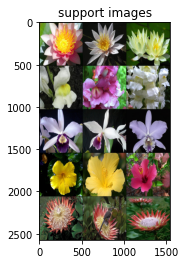

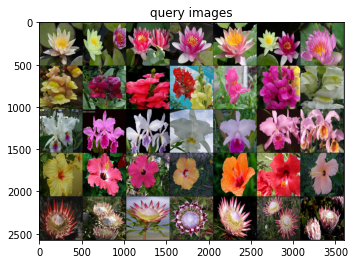

In [10]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)
print(example_support_labels)
print(example_query_labels)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
def training_epoch():
  log_update_frequency = 10

  all_loss = []
  model.train()
  with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
      for episode_index, (
          support_images,
          support_labels,
          query_images,
          query_labels,
          _,
      ) in tqdm_train:
          loss_value = fit(support_images, support_labels, query_images, query_labels)
          all_loss.append(loss_value)

          if episode_index % log_update_frequency == 0:
              tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
              
  return mean(all_loss)

In [13]:
best_state = model.state_dict()
n_epochs=20
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch()
    validation_accuracy = evaluate(val_loader)

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = model.state_dict()
    print("best validation accuracy yet: ", best_validation_accuracy)

Epoch 0


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

Model tested on 100 tasks. Accuracy: 67.37%
best validation accuracy yet:  0.6737142857142857
Epoch 1



100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Model tested on 100 tasks. Accuracy: 78.11%
best validation accuracy yet:  0.7811428571428571
Epoch 2



100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Model tested on 100 tasks. Accuracy: 83.06%
best validation accuracy yet:  0.8305714285714285
Epoch 3



100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Model tested on 100 tasks. Accuracy: 85.97%
best validation accuracy yet:  0.8597142857142858
Epoch 4



100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

Model tested on 100 tasks. Accuracy: 85.09%
best validation accuracy yet:  0.8597142857142858
Epoch 5



100%|██████████| 100/100 [01:19<00:00,  1.25it/s]

Model tested on 100 tasks. Accuracy: 86.09%
best validation accuracy yet:  0.8608571428571429
Epoch 6



100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Model tested on 100 tasks. Accuracy: 84.46%
best validation accuracy yet:  0.8608571428571429
Epoch 7



100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

Model tested on 100 tasks. Accuracy: 86.37%
best validation accuracy yet:  0.8637142857142858
Epoch 8



100%|██████████| 100/100 [01:19<00:00,  1.26it/s]

Model tested on 100 tasks. Accuracy: 87.66%
best validation accuracy yet:  0.8765714285714286
Epoch 9



100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

Model tested on 100 tasks. Accuracy: 87.54%
best validation accuracy yet:  0.8765714285714286
Epoch 10



100%|██████████| 100/100 [01:19<00:00,  1.25it/s]

Model tested on 100 tasks. Accuracy: 85.57%
best validation accuracy yet:  0.8765714285714286
Epoch 11



100%|██████████| 100/100 [01:19<00:00,  1.25it/s]

Model tested on 100 tasks. Accuracy: 86.54%
best validation accuracy yet:  0.8765714285714286
Epoch 12



100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

Model tested on 100 tasks. Accuracy: 86.57%
best validation accuracy yet:  0.8765714285714286
Epoch 13



100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

Model tested on 100 tasks. Accuracy: 87.46%
best validation accuracy yet:  0.8765714285714286
Epoch 14



100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Model tested on 100 tasks. Accuracy: 82.37%
best validation accuracy yet:  0.8765714285714286
Epoch 15



100%|██████████| 100/100 [01:24<00:00,  1.19it/s]

Model tested on 100 tasks. Accuracy: 83.26%
best validation accuracy yet:  0.8765714285714286
Epoch 16



100%|██████████| 100/100 [01:23<00:00,  1.19it/s]

Model tested on 100 tasks. Accuracy: 87.83%
best validation accuracy yet:  0.8782857142857143
Epoch 17



100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

Model tested on 100 tasks. Accuracy: 88.23%
best validation accuracy yet:  0.8822857142857143
Epoch 18



100%|██████████| 100/100 [01:22<00:00,  1.21it/s]

Model tested on 100 tasks. Accuracy: 88.51%
best validation accuracy yet:  0.8851428571428571
Epoch 19



100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

Model tested on 100 tasks. Accuracy: 87.66%
best validation accuracy yet:  0.8851428571428571


In [15]:
model.load_state_dict(best_state)

<All keys matched successfully>

In [16]:
evaluate(test_loader)

100%|██████████| 1000/1000 [36:35<00:00,  2.20s/it]

Model tested on 1000 tasks. Accuracy: 87.28%


0.8728285714285714